In [1]:
import pandas as pd
import numpy as np
from numpy.random import seed
import random
import warnings
warnings.filterwarnings('ignore')
seed(2020) #set random seed

### Load the processed data, note that we've already converted the dcd/pdb file to csv file. 

In [2]:
df_pca=pd.read_csv('./Ala13/PCAanalysis.csv',names=['PCA1','PCA2'])
df_cor=pd.read_csv('./Ala13/Atoms_coordinates_whole.csv',header=None)

In [3]:
df_pca.head()

,PCA1,PCA2
0,0.0162,0.002330
1,0.0164,0.000557
2,0.0168,-0.000337
3,0.0175,-0.001910
4,0.0177,-0.001320


In [4]:
df_cor.head()

,0,1,2,3,4,5,6,7,8,9,...,188,189,190,191,192,193,194,195,196,197
0,30.130003,30.730001,33.320004,28.780001,30.370003,32.850002,27.740002,31.210001,33.570000,28.580000,...,18.540001,20.970001,20.630001,18.210001,21.800001,19.700001,18.200001,19.960001,20.500002,17.490002
1,30.582726,31.034544,33.609142,29.322193,30.378710,33.246048,28.169268,31.027327,34.018612,29.069057,...,18.046659,21.080175,19.482227,17.698109,21.676388,18.441927,18.062536,20.435606,19.408522,16.636789
2,27.547211,30.999948,33.498272,28.881954,30.967804,32.882378,29.850468,30.103348,33.687733,28.909615,...,17.698475,21.072111,20.966135,17.106026,21.194897,19.720905,17.171005,20.400530,21.533232,16.229221
3,27.889790,30.885441,33.714222,29.036554,30.401567,32.932556,29.474493,29.073942,33.540764,28.938217,...,18.102945,22.408243,19.916569,17.357298,23.642900,19.738064,17.475031,21.699007,19.404203,16.474821
4,27.751440,29.981630,33.914619,28.425182,30.937717,33.022114,29.750643,31.394354,33.635334,28.520418,...,18.586025,21.225840,20.214525,17.992739,22.343639,20.065355,17.446964,20.361906,19.368549,17.718796


### Concatenate the PCA values and its corresponding trajectories,here we regard PC1/PC2 values as labels in machine learning tasks.

In [5]:
train_data=np.concatenate((df_pca,df_cor),axis=1)
train_data.shape, df_pca.shape, df_cor.shape
train_data[:2]

array([[1.62000000e-02, 2.33000000e-03, 3.01300030e+01, 3.07300014e+01,
        3.33200035e+01, 2.87800007e+01, 3.03700028e+01, 3.28500023e+01,
        2.77400017e+01, 3.12100010e+01, 3.35699997e+01, 2.85799999e+01,
        3.03899994e+01, 3.13400002e+01, 2.79200001e+01, 2.94400024e+01,
        3.09200020e+01, 2.90000000e+01, 3.14500027e+01, 3.06500015e+01,
        2.90800018e+01, 3.16399994e+01, 2.92200012e+01, 3.00400009e+01,
        3.27800026e+01, 2.88800030e+01, 2.94800014e+01, 3.03199997e+01,
        2.85600014e+01, 2.88500023e+01, 2.98400021e+01, 2.76200008e+01,
        3.04900017e+01, 2.96400032e+01, 2.91000004e+01, 3.10700016e+01,
        2.84600029e+01, 2.84799995e+01, 3.25200005e+01, 2.82200012e+01,
        2.89000015e+01, 3.02100010e+01, 2.72100029e+01, 2.86100006e+01,
        2.99600010e+01, 2.65200024e+01, 2.76300030e+01, 2.97900009e+01,
        2.69100017e+01, 2.98400021e+01, 2.89300003e+01, 2.58100014e+01,
        3.02300034e+01, 2.88900013e+01, 2.57200012e+01, 3.175000

In [6]:
np.random.shuffle(train_data)
train_dataset=train_data[:2000]
test_dataset=train_data[2000:]

In [7]:
train_dataset_pd=pd.DataFrame(train_dataset)
#train_dataset_pd
test_dataset_pd=pd.DataFrame(test_dataset)
#train_dataset_pd.to_csv('train_data.csv',header=None,index=None)
#test_dataset_pd.to_csv('test_data_500.csv',header=None,index=None)

In [8]:
X_test=test_dataset[:,:2]
Y_test=test_dataset[:,2:]
X_train=train_dataset[:,:2]
Y_train=train_dataset[:,2:]
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((2000, 2), (2000, 198), (500, 2), (500, 198))

### Data Normalisation

In [9]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
# note that we must define two minmaxscalers
scalar1 = MinMaxScaler()
scalar2 = MinMaxScaler()

In [10]:
X_scaled_train=scalar1.fit_transform(X_train)
Y_scaled_train=scalar2.fit_transform(Y_train)
X_scaled_test=scalar1.transform(X_test)
Y_scaled_test=scalar2.transform(Y_test)

### Build the neural network model

In [11]:
from keras.models import Sequential
from keras.layers import Input,Dense, Activation
from keras.layers import Dropout
from keras import regularizers
from keras.losses import mean_squared_error, binary_crossentropy
from keras import objectives
from keras.models import Model
from keras.utils import plot_model
from keras import optimizers

Using TensorFlow backend.


In [12]:
latent_dim = 2
intermediate_dim_1=16
intermediate_dim_2=32
intermediate_dim_3=64
original_dim=198
#Encoder part
input_net=Input(shape=(original_dim,), name="embeding")
encoded_h_3 = Dense(intermediate_dim_3, activation='relu', name="hiddenLayer1",kernel_initializer='normal')(input_net)
encoded_h_2 = Dense(intermediate_dim_2, activation='relu', name="hiddenLayer2",kernel_initializer='normal')(encoded_h_3)
encoded_h_1 = Dense(intermediate_dim_1, activation='relu', name="hiddenLayer3",kernel_initializer='normal')(encoded_h_2)
PCA=Dense(latent_dim, activation='sigmoid', name="encode_out",kernel_initializer='normal')(encoded_h_1)

#PCA=Dense(latent_dim, activation='relu', name="encode_out")(input_net)
#Decoder part
decoded_h_1= Dense(intermediate_dim_1,kernel_initializer='normal', activation='relu', name="hiddenLayer4")(PCA)
decoded_h_2= Dense(intermediate_dim_2,kernel_initializer='normal', activation='relu', name="hiddenLayer5")(decoded_h_1)
decoded_h_3= Dense(intermediate_dim_3,kernel_initializer='normal', activation='relu', name="hiddenLayer6")(decoded_h_2)
decoded = Dense(original_dim,kernel_initializer='normal', activation='sigmoid', name="decode_out")(decoded_h_3)
#decoded = Dense(original_dim, activation='sigmoid', name="decode_out")(PCA)
# end-to-end autoencoder
autoencoder = Model(inputs=input_net, outputs=[PCA, decoded], name="AutoEncoder")

### Define the loss function, we use the mse loss function in two different part in modified AE 

In [13]:
def latent_loss(y_true, y_pred):
    return mean_squared_error(y_true,y_pred)

# loss compile
adam=optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.99, epsilon=1e-08)
autoencoder.compile(optimizer=adam,
              loss={'encode_out': latent_loss,'decode_out': latent_loss},
              loss_weights={'encode_out':1, 'decode_out': 1},
              metrics=["mean_squared_error"])

### Show the structure of autoencoder model

In [14]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embeding (InputLayer)        (None, 198)               0         
_________________________________________________________________
hiddenLayer1 (Dense)         (None, 64)                12736     
_________________________________________________________________
hiddenLayer2 (Dense)         (None, 32)                2080      
_________________________________________________________________
hiddenLayer3 (Dense)         (None, 16)                528       
_________________________________________________________________
encode_out (Dense)           (None, 2)                 34        
_________________________________________________________________
hiddenLayer4 (Dense)         (None, 16)                48        
_________________________________________________________________
hiddenLayer5 (Dense)         (None, 32)                544       
__________

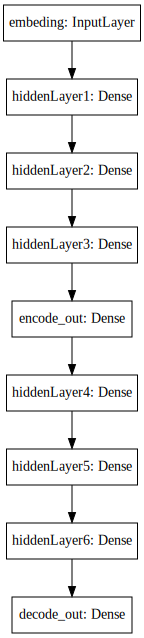

In [15]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
plot_model(autoencoder, to_file='ModifiedAE.png')
SVG(model_to_dot(autoencoder).create(prog='dot', format='svg'))

In [16]:
history=autoencoder.fit(Y_scaled_train,[X_scaled_train, Y_scaled_train],
                shuffle=True,
                epochs=100,
                batch_size=8,
                validation_data=(Y_scaled_test,[X_scaled_test,Y_scaled_test]))

Train on 2000 samples, validate on 500 samples
Epoch 1/100
2000/2000 [==============================] - 3s 1ms/step - loss: 0.0511 - encode_out_loss: 0.0274 - decode_out_loss: 0.0237 - encode_out_mean_squared_error: 0.0274 - decode_out_mean_squared_error: 0.0237 - val_loss: 0.0274 - val_encode_out_loss: 0.0053 - val_decode_out_loss: 0.0222 - val_encode_out_mean_squared_error: 0.0053 - val_decode_out_mean_squared_error: 0.0222
Epoch 2/100
2000/2000 [==============================] - 1s 290us/step - loss: 0.0237 - encode_out_loss: 0.0035 - decode_out_loss: 0.0201 - encode_out_mean_squared_error: 0.0035 - decode_out_mean_squared_error: 0.0201 - val_loss: 0.0226 - val_encode_out_loss: 0.0025 - val_decode_out_loss: 0.0202 - val_encode_out_mean_squared_error: 0.0025 - val_decode_out_mean_squared_error: 0.0202
Epoch 3/100
2000/2000 [==============================] - 1s 291us/step - loss: 0.0200 - encode_out_loss: 0.0019 - decode_out_loss: 0.0181 - encode_out_mean_squared_error: 0.0019 - decod

In [17]:
autoencoder.save('autoencoder_model.h5')
del autoencoder

### Load the previous model and utilise the decoder part to predict the given testing data

In [18]:
# generator, from latent space to reconstructed inputs
decoder_input = Input(shape=(latent_dim,))
#decoded_h = Dense(intermediate_dim, activation="relu", name="hiddenLayer2")(decoder_input)
#decoded = Dense(original_dim, activation='relu', name="decode_out")(decoded_h)

decoded_h_1= Dense(intermediate_dim_1,kernel_initializer='normal', activation='relu', name="hiddenLayer4")(decoder_input)
decoded_h_2= Dense(intermediate_dim_2,kernel_initializer='normal', activation='relu', name="hiddenLayer5")(decoded_h_1)
decoded_h_3= Dense(intermediate_dim_3,kernel_initializer='normal', activation='relu', name="hiddenLayer6")(decoded_h_2)
decoded = Dense(original_dim,kernel_initializer='normal', activation='sigmoid', name="decode_out")(decoded_h_3)

generator = Model(decoder_input, decoded)
# load weights from first model by name
generator.load_weights('autoencoder_model.h5', by_name=True)

AttributeError: 'str' object has no attribute 'decode'

### Plot the training and testing loss

In [20]:
import matplotlib.pyplot as plt

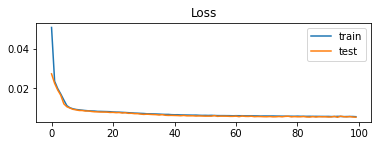

In [21]:
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

In [22]:
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
hiddenLayer4 (Dense)         (None, 16)                48        
_________________________________________________________________
hiddenLayer5 (Dense)         (None, 32)                544       
_________________________________________________________________
hiddenLayer6 (Dense)         (None, 64)                2112      
_________________________________________________________________
decode_out (Dense)           (None, 198)               12870     
Total params: 15,574
Trainable params: 15,574
Non-trainable params: 0
_________________________________________________________________


In [23]:
X_scaled_test.shape, Y_scaled_test.shape

((500, 2), (500, 198))

### Load the 7 testing structures 

In [24]:
predict_dataset=pd.read_csv('./Ala13/new_testing_data_7.csv',names=['PCA1','PCA2'])
predict_dataset.dropna(axis=0, how='any', inplace=True)

In [25]:
predict_dataset=scalar1.transform(predict_dataset)

### Predict the 7 testing structures

In [26]:
pred=generator.predict(predict_dataset, batch_size=16)
print(pred)
save=pd.DataFrame(pred)

[[0.4999922  0.5000041  0.49997604 ... 0.5000143  0.49998653 0.49999666]
 [0.49996197 0.5000227  0.49992526 ... 0.50005776 0.49994063 0.49997902]
 [0.4999473  0.50003785 0.4999086  ... 0.5000867  0.49991596 0.4999671 ]
 ...
 [0.49999774 0.5000384  0.499947   ... 0.5000521  0.49992335 0.4999714 ]
 [0.49999917 0.5000425  0.49994493 ... 0.5000562  0.49990538 0.4999606 ]
 [0.49999833 0.5000173  0.49997813 ... 0.50002474 0.4999529  0.49997926]]


In [27]:
y_pred=scalar2.inverse_transform(save)

In [28]:
y_pred

array([[30.26544 , 31.88873 , 29.635094, ..., 24.582815, 20.604979,
        21.583393],
       [30.26513 , 31.888872, 29.63453 , ..., 24.583752, 20.604136,
        21.583044],
       [30.26498 , 31.888988, 29.634342, ..., 24.584375, 20.603683,
        21.58281 ],
       ...,
       [30.265495, 31.888992, 29.63477 , ..., 24.583628, 20.603819,
        21.582895],
       [30.26551 , 31.88902 , 29.634747, ..., 24.583717, 20.603489,
        21.58268 ],
       [30.265503, 31.888828, 29.635118, ..., 24.58304 , 20.604362,
        21.58305 ]], dtype=float32)

In [29]:
y_pred=pd.DataFrame(y_pred)

In [30]:
y_pred

,0,1,2,3,4,5,6,7,8,9,...,188,189,190,191,192,193,194,195,196,197
0,30.265440,31.888729,29.635094,30.148331,31.843025,29.922089,30.114326,31.393517,29.950163,30.119411,...,21.755301,24.324160,20.522970,21.855049,24.417492,20.591421,22.188961,24.582815,20.604979,21.583393
1,30.265129,31.888872,29.634529,30.148327,31.842598,29.922001,30.114237,31.393717,29.949099,30.119822,...,21.755257,24.323568,20.522905,21.856215,24.417107,20.591307,22.189987,24.583752,20.604136,21.583044
2,30.264980,31.888988,29.634342,30.148325,31.842390,29.921965,30.114161,31.393692,29.948618,30.119944,...,21.755262,24.323299,20.522976,21.856726,24.416952,20.591352,22.190575,24.584375,20.603683,21.582809
3,30.265509,31.889017,29.634752,30.148378,31.842648,29.921673,30.114033,31.393520,29.949329,30.119621,...,21.755716,24.323648,20.523434,21.855877,24.417381,20.591640,22.190439,24.583696,20.603582,21.582741
4,30.265495,31.888992,29.634769,30.148424,31.842684,29.921755,30.114086,31.393465,29.949442,30.119570,...,21.755585,24.323832,20.523298,21.855764,24.417446,20.591536,22.190201,24.583628,20.603819,21.582895
5,30.265511,31.889021,29.634747,30.148357,31.842636,29.921646,30.114016,31.393539,29.949289,30.119638,...,21.755774,24.323576,20.523487,21.855907,24.417360,20.591679,22.190525,24.583717,20.603489,21.582680
6,30.265503,31.888828,29.635118,30.148281,31.842953,29.921902,30.114225,31.393440,29.950041,30.119400,...,21.755646,24.323936,20.523232,21.855217,24.417452,20.591669,22.189562,24.583040,20.604362,21.583050


### Save the results for predicting

In [31]:
y_pred.to_csv('new_results_7.csv',index=False,header=False)